In [3]:
%pip install torch
%pip install matplotlib
%pip install numpy


     ---------------------------------------- 8.1/8.1 MB 276.4 kB/s eta 0:00:00
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
     ---------------------------------------- 2.2/2.2 MB 1.0 MB/s eta 0:00:00
  Using cached pyparsing-3.2.3-py3-none-any.whl (111 kB)
     -------------------------------------- 12.9/12.9 MB 726.9 kB/s eta 0:00:00
     -------------------------------------- 71.9/71.9 kB 395.2 kB/s eta 0:00:00
     ------------------------------------ 221.2/221.2 kB 518.3 kB/s eta 0:00:00
     ---------------------------------------- 2.7/2.7 MB 476.6 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Raycast-Based Ball Position & Velocity Prediction
# Inspired by biological vision

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
# CNN + LSTM Gated Fusion Model for Biologically Inspired Object Tracking
# Input: 1D raycast data simulating "vision"
# Output: Position and velocity prediction using learned gating



In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU: CUDA")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: CUDA


# 1. Simulated Raycast Generator

In [3]:
# def simulate_raycast_sequence(seq_len=5, num_rays=16, fov=np.pi, ball_radius=0.1):
#     ray_angles = np.linspace(-fov / 2, fov / 2, num_rays)
#     ball_pos = np.random.uniform(low=[-1, 0.2], high=[1, 0.8])
#     ball_vel = np.random.uniform(low=[-0.05, -0.02], high=[0.05, 0.02])

#     eyeball_pos = np.array([0.0, 0.0])
#     raycast_sequence = []
#     position_sequence = []

#     for t in range(seq_len):
#         rays = []
#         ball_c = ball_pos + ball_vel * t

#         for angle in ray_angles:
#             dir_vec = np.array([np.cos(angle), np.sin(angle)])
#             oc = ball_c - eyeball_pos
#             b = 2 * np.dot(oc, dir_vec)
#             c = np.dot(oc, oc) - ball_radius**2
#             discriminant = b**2 - 4 * c
#             if discriminant < 0:
#                 rays.append(10.0)  # No hit
#             else:
#                 dist = (-b - np.sqrt(discriminant)) / 2
#                 rays.append(max(dist, 0.0))

#         raycast_sequence.append(rays)
#         position_sequence.append(ball_c)

#     raycast_sequence = np.array(raycast_sequence)  # (T, R)
#     position_sequence = np.array(position_sequence)  # (T, 2)
#     velocity = ball_vel  # (2,)
#     return raycast_sequence, position_sequence, velocity

In [4]:
# Generate dataset
# X_rays, Y_pos, Y_vel = [], [], []
# for _ in range(5000):
#     rays, pos, vel = simulate_raycast_sequence()
#     X_rays.append(rays)
#     Y_pos.append(pos)
#     Y_vel.append(vel)

# X_rays = np.stack(X_rays)  # (N, T, R)
# Y_pos = np.stack(Y_pos)    # (N, T, 2)
# Y_vel = np.stack(Y_vel)    # (N, 2)

# # Predict final frame only
# Y_pos_final = Y_pos[:, -1, :]  # position at last time step


# Load Data

In [5]:
# X_rays = np.load('../data/CNN_LSTM_rays.npy')  # (N, T, R)
# Y_pos =  np.load('../data/CNN_LSTM_pos.npy')    # (N, T, 2)
# Y_vel =  np.load('../data/CNN_LSTM_vel.npy')    # (N, 2)
X_rays = np.load('../data/CNN_LSTM/big_rays.npy')  # (N, T, R)
Y_pos =  np.load('../data/CNN_LSTM/big_pos.npy')    # (N, T, 2)
Y_vel =  np.load('../data/CNN_LSTM/big_vel.npy')    # (N, 2)
print("X_rays shape:", X_rays.shape)
print("Y_pos shape:", Y_pos.shape)
print("Y_vel shape:", Y_vel.shape)

Y_pos_final = Y_pos[:, -1, :]  # position at last time step

X_rays shape: (623757, 5, 107)
Y_pos shape: (623757, 5, 2)
Y_vel shape: (623757, 2)


In [6]:
print(np.mean(Y_pos_final, axis=0), np.std(Y_pos_final, axis=0))

[-1.22759557  0.29534447] [0.81376845 0.4431114 ]


# Visualize a Sample

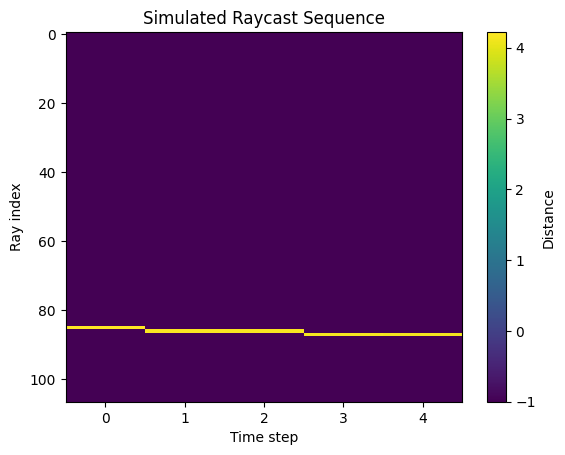

In [7]:
def visualize_rays(ray_seq):
    plt.imshow(ray_seq.T, aspect='auto', cmap='viridis')
    plt.xlabel("Time step")
    plt.ylabel("Ray index")
    plt.title("Simulated Raycast Sequence")
    plt.colorbar(label="Distance")
    plt.show()

visualize_rays(X_rays[6])



# Model Definition

In [8]:
from CNN_LSTM import VisualCNN, MotionLSTM, GatingNetwork, GatedFusionModel

# class VisualCNN(nn.Module):
#     def __init__(self, num_rays):
#         super().__init__()
#         self.cnn = nn.Sequential(
#             nn.Conv1d(1, 16, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.Conv1d(16, 32, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.AdaptiveAvgPool1d(1)
#         )
#         self.fc = nn.Linear(32, 2)  # Predict x, y position

#     def forward(self, x):
#         x = x.unsqueeze(1)  # (B, 1, R)
#         features = self.cnn(x).squeeze(-1)  # (B, 32)
#         return self.fc(features)  # (B, 2)

# class MotionLSTM(nn.Module):
#     def __init__(self, input_size=2, hidden_size=32):
#         super().__init__()
#         self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
#         self.fc = nn.Linear(hidden_size, 4)  # Predict x, y, vx, vy

#     def forward(self, x):
#         out, _ = self.lstm(x)  # (B, T, H)
#         return self.fc(out[:, -1])  # (B, 4)

# class GatingNetwork(nn.Module):
#     def __init__(self, input_size):
#         super().__init__()
#         self.fc = nn.Sequential(
#             nn.Linear(input_size, 32),
#             nn.ReLU(),
#             nn.Linear(32, 1),
#             nn.Sigmoid()
#         )

#     def forward(self, cnn_feat, lstm_feat):
#         x = torch.cat([cnn_feat, lstm_feat], dim=-1)
#         return self.fc(x)  # scalar gate between 0 and 1

# class GatedFusionModel(nn.Module):
#     def __init__(self, num_rays):
#         super().__init__()
#         self.visual_cnn = VisualCNN(num_rays)
#         self.motion_lstm = MotionLSTM()
#         self.gating_net = GatingNetwork(input_size=6)  # [x,y] from CNN + [x,y,vx,vy] from LSTM

#     def forward(self, rays_seq, pos_seq):
#         cnn_input = rays_seq[:, -1, :]  # last frame (B, R)
#         lstm_input = pos_seq  # (B, T, 2)

#         v_spatial = self.visual_cnn(cnn_input)  # (B, 2)
#         l_spatial = self.motion_lstm(lstm_input)  # (B, 4)

#         g = self.gating_net(v_spatial, l_spatial)  # (B, 1)
#         s_pos = g * v_spatial + (1 - g) * l_spatial[:, :2]  # final position
#         s_vel = l_spatial[:, 2:]  # only LSTM predicts velocity
#         return torch.cat([s_pos, s_vel], dim=-1)  # (B, 4)

# Training

In [9]:
X_tensor = torch.tensor(X_rays, dtype=torch.float32)  # (N, T, R)
Y_target = torch.tensor(np.concatenate([Y_pos_final, Y_vel], axis=1), dtype=torch.float32)  # (N, 4)

dataset = TensorDataset(X_tensor, Y_target)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

# === Build model ===
model = GatedFusionModel(num_rays=X_rays.shape[2])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# === Train loop ===
losses = []
for epoch in range(50):
    epoch_loss = 0
    percent = (epoch/50)**2

    for xb_rays, yb in loader:
        # pred = model(xb_rays) 
        # loss = criterion(pred, yb)
        prediction = model(xb_rays)
        pred = prediction[:, :4]  # position only
        cnn_pos = prediction[:, 4:]
        # pred, cnn_pos = model(xb_rays)
        loss_main = criterion(pred, yb)
        loss_cnn = criterion(cnn_pos, yb[:, :2])  # position only
        # loss_cnn = 0

        loss = loss_main + (0.7*(1 - percent)+1)  * loss_cnn  # weighted training (try to make the CNN learn position)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(loader)
    losses.append(avg_loss)
    print(f"Epoch {epoch}: Loss = {avg_loss:.4f}")

# X_tensor = torch.tensor(X_rays, dtype=torch.float32)
# Y_pos_tensor = torch.tensor(Y_pos, dtype=torch.float32)
# Y_target = torch.tensor(np.concatenate([Y_pos_final, Y_vel], axis=1), dtype=torch.float32)

# dataset = TensorDataset(X_tensor, Y_pos_tensor, Y_target)
# loader = DataLoader(dataset, batch_size=32, shuffle=True)

# model = GatedFusionModel(num_rays=X_rays.shape[2])
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# criterion = nn.MSELoss()

# losses = []
# for epoch in range(50):
#     epoch_loss = 0
#     for xb_rays, xb_pos, yb in loader:
#         pred = model(xb_rays, xb_pos)
#         loss = criterion(pred, yb)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         epoch_loss += loss.item()
#     avg_loss = epoch_loss / len(loader)
#     losses.append(avg_loss)
#     print(f"Epoch {epoch}: Loss = {avg_loss:.4f}")

Epoch 0: Loss = 0.6296
Epoch 1: Loss = 0.5390
Epoch 2: Loss = 0.4726
Epoch 3: Loss = 0.4415
Epoch 4: Loss = 0.4266
Epoch 5: Loss = 0.4163
Epoch 6: Loss = 0.4088
Epoch 7: Loss = 0.4019
Epoch 8: Loss = 0.3962
Epoch 9: Loss = 0.3900
Epoch 10: Loss = 0.3864
Epoch 11: Loss = 0.3819
Epoch 12: Loss = 0.3767
Epoch 13: Loss = 0.3731


KeyboardInterrupt: 

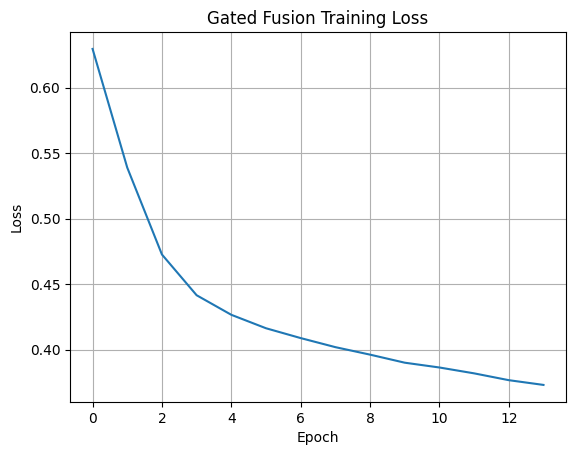

In [10]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Gated Fusion Training Loss")
plt.grid(True)
plt.show()

# Eval

In [11]:
X_rays_test = np.load('../data/CNN_LSTM_test_rays.npy')  # (N, T, R)
Y_pos_test =  np.load('../data/CNN_LSTM_test_pos.npy')    # (N, T, 2)
Y_vel_test =  np.load('../data/CNN_LSTM_test_vel.npy')    # (N, 2)
print("X_rays_test shape:", X_rays_test.shape)
print("Y_pos_test shape:", Y_pos_test.shape)
print("Y_vel_test shape:", Y_vel_test.shape)

Y_pos_final_test = Y_pos_test[:, -1, :]  # position at last time step

X_rays_test shape: (4701, 5, 107)
Y_pos_test shape: (4701, 5, 2)
Y_vel_test shape: (4701, 2)


In [12]:
# model.eval()
# with torch.no_grad():
#     idx = np.random.randint(0, len(X_rays_test))
#     test_ray = torch.tensor(X_rays_test[idx], dtype=torch.float32)
#     test_pos = torch.tensor(Y_pos[idx], dtype=torch.float32)
#     test_vel = torch.tensor(Y_vel[idx], dtype=torch.float32)
#     prediction = model(test_ray, test_pos).numpy()[0]

#     print("Predicted (x, y, vx, vy):", prediction)
#     print("Ground truth (x, y, vx, vy):", np.concatenate([Y_pos_final[idx], Y_vel[idx]]))

model.eval()
with torch.no_grad():
    i = np.random.randint(0, len(X_rays_test))
    test_ray = torch.tensor(X_rays_test[i:i+1], dtype=torch.float32)
    test_pos = torch.tensor(Y_pos_test[i:i+1], dtype=torch.float32)
    # print("Test ray shape:", Y_pos_test[i:i+1].shape)
    # prediction = model(test_ray, torch.zeros((1,5,2))).numpy()[0]
    prediction = model(test_ray).numpy()[0]

    print("Predicted (x, y, vx, vy):", prediction)
    print("Ground truth (x, y, vx, vy):", np.concatenate([Y_pos_final_test[i], Y_vel_test[i]]))


Predicted (x, y, vx, vy): [-1.8930829   0.56869584 -1.8424175  -1.4131768  -1.8002901   0.3210808 ]
Ground truth (x, y, vx, vy): [-2.17271786 -0.10392225 -3.70981602 -5.48327197]


In [13]:
true_vel = []
pred_vel = []
true_pos = []
pred_pos = []

model.eval()
with torch.no_grad():
    idx = np.random.randint(0, len(X_rays_test) - 1, 30)

    for i in idx:
        test_ray = torch.tensor(X_rays_test[i:i+1], dtype=torch.float32)
        test_pos = torch.tensor(Y_pos_test[i:i+1], dtype=torch.float32)
        prediction = model(test_ray).numpy()[0]

        true_pos.append(Y_pos_final_test[i])
        true_vel.append(Y_vel_test[i])
        pred_pos.append(prediction[:2])
        pred_vel.append(prediction[2:4])

    # print("Predicted (x, y, vx, vy):", prediction)
    # print("Ground truth (x, y, vx, vy):", np.concatenate([Y_pos_final_test[i], Y_vel_test[i]]))

In [14]:
x_coords_true_vel, y_coords_true_vel = zip(*true_vel)
x_coords_pred_vel, y_coords_pred_vel = zip(*pred_vel)
x_coords_true_pos, y_coords_true_pos = zip(*true_pos)
x_coords_pred_pos, y_coords_pred_pos = zip(*pred_pos)

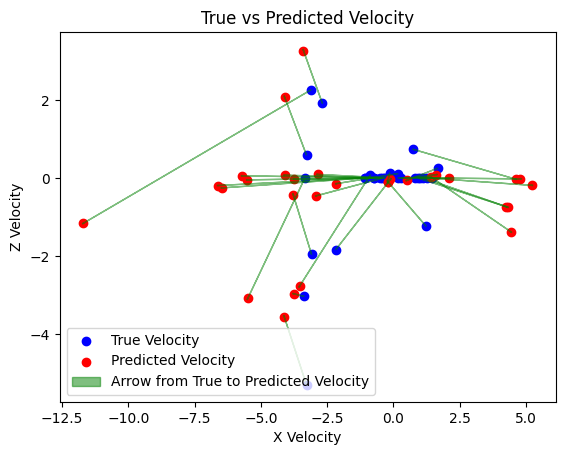

In [15]:
plt.scatter(x_coords_true_vel, y_coords_true_vel, color='blue', label='True Velocity')
plt.scatter(x_coords_pred_vel, y_coords_pred_vel, color='red', label='Predicted Velocity')
for i in range(len(x_coords_true_vel)):
    plt.arrow(x_coords_true_vel[i], y_coords_true_vel[i], x_coords_pred_vel[i]-x_coords_true_vel[i], y_coords_pred_vel[i]-y_coords_true_vel[i], 
              head_width=0.02, head_length=0.05, fc='green', ec='green', alpha=0.5, label="Arrow from True to Predicted Velocity" if i == 0 else "")
plt.title("True vs Predicted Velocity")
plt.xlabel("X Velocity")
plt.ylabel("Z Velocity")
plt.legend()


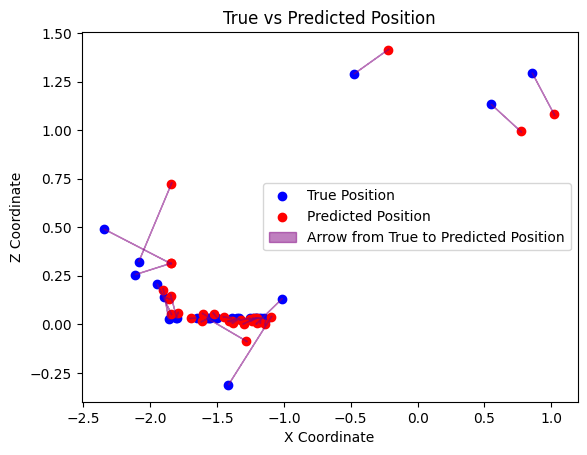

In [16]:
plt.scatter(x_coords_true_pos, y_coords_true_pos, color='blue', label='True Position')
plt.scatter(x_coords_pred_pos, y_coords_pred_pos, color='red', label='Predicted Position')
for i in range(len(x_coords_true_vel)):
    plt.arrow(x_coords_true_pos[i], y_coords_true_pos[i], x_coords_pred_pos[i]-x_coords_true_pos[i], y_coords_pred_pos[i]-y_coords_true_pos[i], 
              head_width=0.005, head_length=0.01, fc='purple', ec='purple', alpha=0.5, label="Arrow from True to Predicted Position" if i == 0 else "")
plt.title("True vs Predicted Position")
plt.xlabel("X Coordinate")
plt.ylabel("Z Coordinate")
plt.legend()

# Save Model

In [ ]:
torch.save(model.state_dict(), "gated_model.pth")